In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

from badlands import meshtools 
from badlands import TreMesh
from badlands import HeightMesh
from badlands import SurfaceProcessMesh

import numpy as np

In [3]:
# %%prun -s cumulative -q -l 10 -T prunMeshBuild

# Build a higher resolution mesh which we can use to test the erosion toolkit

x1, y1, bmask, inverse_bmask = meshtools.elliptical_mesh(-5.0, 5.0, -5.0,  5.0, 0.05, 0.05, 100000, 150 )
x5,y5 = meshtools.lloyd_mesh_improvment(x1,y1, bmask, 5)
z5 = np.exp(-0.025*(x5**2 + y5**2)**2) + 0.0001 * np.random.rand(len(x5))
z5 -= z5[inverse_bmask].mean()     # Boundary is at zero which we define as the base level

r5 = z5**2 # Rainfall pattern

mesh5 = SurfaceProcessMesh(x5, y5, z5, r5, None, None, bmask, verbose=True)


Origin =  0.0 0.0 Radius =  5.0 Aspect =  1.0
 - Calculating Delaunay Triangulation  0.701812 s
 - Triangulation Neighbour Lists  3.232298 s
 - Triangulation Local Areas and Weights  2.21653 s
 - Triangulation Vector Operators  2.533166 s
 - Local Smoothing Operator  0.464642 s
 - Sorted all nodes by height (high to low)  0.268689 s
 - Built downhill matrices  0.292475 s
 - Built cumulative area 0.165314 s
 - Found low points 0.041736 s
 - Found outflow points 0.035888 s


depo min/max, mean 0.0 3255.62452428 0.0413223735724
depo min/max, mean 0.0 3262.1002633 0.0414045676046
depo min/max, mean 0.0 3275.37181333 0.0415730182181


/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


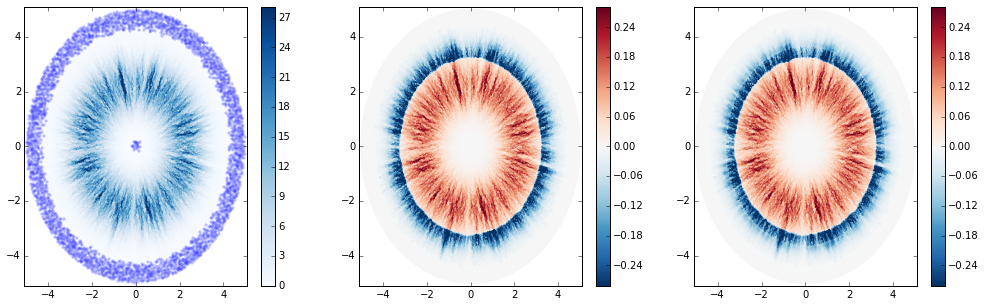

In [4]:
# This is how to obtain the erosion rate / deposition rate 

# mesh5.update_height(z5)
# mesh5.update_surface_processes()

# erosion_rate, deposition_rate, stream_power = mesh5.stream_power_erosion_deposition_rate(0.01, 0, 0, 0, 0)
# erosion_deposition_rate = erosion_rate - deposition_rate

erosion_rate, deposition_rate, stream_power = \
         mesh5.stream_power_erosion_deposition_rate2(efficiency=0.01, 
                                                    smooth_power=0, 
                                                    smooth_low_points=2, 
                                                    smooth_erosion_rate=0, 
                                                    smooth_deposition_rate=2, 
                                                    smooth_operator=mesh5.downhill_smoothing,
                                                    centre_weight_u=0.75, centre_weight=0.5)

    
    
erosion_deposition_rate = erosion_rate - deposition_rate

flat_spots = mesh5.identify_flat_spots()
smoothed_deposition_rate = deposition_rate.copy()
smoothed_deposition_rate[np.invert(flat_spots)] = 0.0

#for i in range(0, 5):
smoothed_deposition_rate = mesh5.local_area_smoothing(smoothed_deposition_rate, its=2, centre_weight=0.5)
    # smoothed_deposition_rate = mesh5.downhill_smoothing(smoothed_deposition_rate, its=1, centre_weight=0.5)

deposition_rate[flat_spots] = smoothed_deposition_rate[flat_spots]
     
erosion_deposition_rate2 = erosion_rate - deposition_rate


print "depo min/max, mean", deposition_rate.min(), deposition_rate.sum(), deposition_rate.mean()

deposition_rate2 = mesh5.streamwise_smoothing(deposition_rate, 5)

print "depo min/max, mean", deposition_rate2.min(), deposition_rate2.sum(), deposition_rate2.mean()

deposition_rate3 = mesh5.local_area_smoothing(deposition_rate, 5, centre_weight=0.5)
print "depo min/max, mean", deposition_rate3.min(), deposition_rate3.sum(), deposition_rate3.mean()

not_so_low_points = []
for node in mesh5.low_points:
    if mesh5.height[node] > 0.005 * mesh5.height.max():
        not_so_low_points.append(node)

fig, (plot1, plot2, plot3) = plt.subplots(1,3)
fig.set_size_inches(17,5)

plot1.set_xlim(-5.1, 5.1)
plot1.set_ylim(-5.1, 5.1)
plot2.set_xlim(-5.1, 5.1)
plot2.set_ylim(-5.1, 5.1)
plot3.set_xlim(-5.1, 5.1)
plot3.set_ylim(-5.1, 5.1)


maxED  =    erosion_deposition_rate[bmask].max() / 2.0 
maxPWR =    stream_power[bmask].max() / 2.0
#maxCUM =    cumulative_rain[bmask].max() / 2.0

sm1 = mesh5.add_node_data_to_plot(plot1, stream_power, vmin=0.0, vmax=maxPWR, cmap=cm.Blues,  shading="gouraud")
#plot1.tricontour(mesh5.x, mesh5.y, mesh5.tri.simplices.copy(), mesh5.height, (0.001, 0.01, 0.1, 0.99))
#sm1b = mesh5.add_node_data_to_plot(plot1, mesh5.rainfall_pattern, cmap=cm.BrBG, shading="gouraud", alpha=0.1)
plot1.scatter(mesh5.x[mesh5.low_points], mesh5.y[mesh5.low_points],10, marker="o", alpha=0.25, linewidth=0.0)


fig.colorbar(sm1, ax=plot1)

sm2 = mesh5.add_node_data_to_plot(plot2, erosion_deposition_rate, vmin=-maxED, vmax=maxED, cmap=cm.RdBu_r,  shading="gouraud") #, vmax=maxDR)
fig.colorbar(sm2, ax=plot2)

sm3 = mesh5.add_node_data_to_plot(plot3, erosion_deposition_rate2, vmin=-maxED, vmax=maxED, cmap=cm.RdBu_r,  shading="gouraud") #, vmax=maxDR)
fig.colorbar(sm3, ax=plot3)

fig.savefig("erosion-deposition-power.png", dpi=300)
#plt.close()


In [5]:
%%sh

open erosion-deposition-power.png

<function matplotlib.pyplot.show>

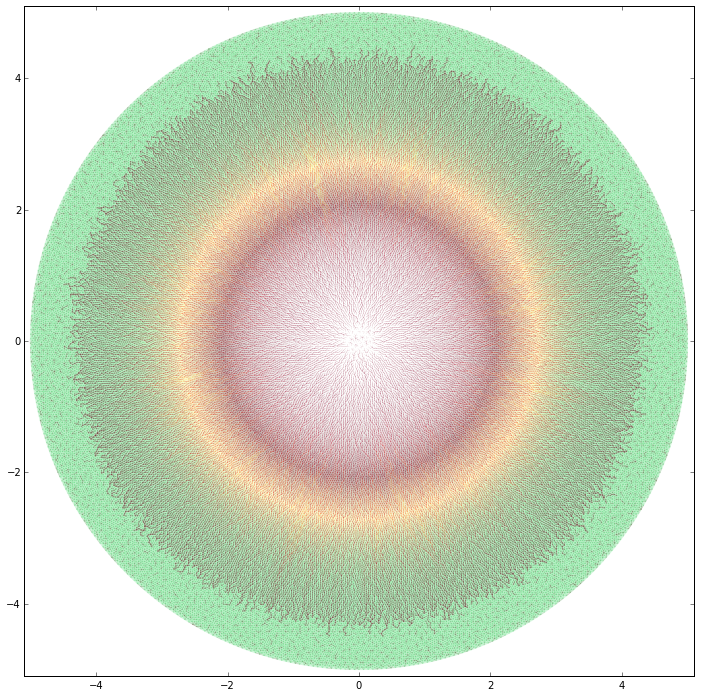

In [6]:
mesh5.build_node_chains()

fig = plt.figure(figsize=(12, 12), facecolor="none")
# plt.xlim(minX, maxX)
# plt.ylim(minY, maxY)

plt.xlim(-5.1,5.1)
plt.ylim(-5.1,5.1)

power = mesh5.slope * mesh5.upstream_area # each to some power, but this is a good start.

log_upstream_area = np.log(mesh5.upstream_area)
# downstream_dist   = mesh5.node_downstream_distance

stream_color_var = power
stream_width_var = log_upstream_area

norm1 = plt.Normalize(vmin=stream_color_var.min(), vmax=stream_color_var.max())
norm2 = plt.Normalize(vmin=stream_width_var.min(), vmax=stream_width_var.max())

for idx, chain in enumerate(mesh5.node_chain_list[-1:0:-1]):
    xx = mesh5.tri.points[chain].T[0]
    yy = mesh5.tri.points[chain].T[1]
    
    for nn,node in enumerate(chain[0:-1]):
        xs = (xx[nn], xx[nn+1])
        ys = (yy[nn], yy[nn+1])
    
        color = plt.cm.YlOrRd_r( norm1(stream_color_var[node]) )
        width = 1.5 * norm2(stream_width_var[node])
        plt.plot(xs,ys, color=color, alpha=0.25, marker="", linewidth=width)
    
    

# plt.triplot(x, y, tri.simplices.copy(), linewidth=0.5, color="#AABBBB", zorder=2)
plt.tripcolor(mesh5.x, mesh5.y, mesh5.tri.simplices.copy(), mesh5.height, cmap=cm.terrain, shading="gouraud", vmin=-0.5, alpha=0.25)
  
plt.show 

In [7]:
fig.savefig("SombreroChains.png", dpi=600)    

In [8]:
%%sh

open SombreroChains.png

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130


KeyboardInterrupt: 

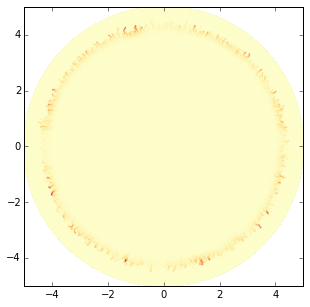

In [9]:
## Make a series of plots to show the flow of information on this mesh

# vector = mesh5.area.copy()

vector = np.ones(mesh5.tri.npoints)

DX0 = vector.copy()
DX1 = vector.copy()

fig, (plot1) = plt.subplots(1,1)
fig.set_size_inches(5,5)

plot1.axes.set_aspect("equal")

lim = 5.0
plot1.set_xlim(-lim, lim)
plot1.set_ylim(-lim, lim)

step=0
while DX1.any() and step < 150: 
    print step
    
    if step%5==0 or step < 10:
        plot1.triplot(mesh5.x, mesh5.y, mesh5.tri.simplices, color="Black", linewidth=0.1, alpha=0.5, zorder=0)
        sm1 = mesh5.add_node_data_to_plot(plot1, DX1, vmin=0.0, vmax=1.0, cmap=cm.YlOrRd, shading="gouraud", alpha=0.5, zorder=1)
        fig.savefig("SombreroInfoPropagation.{:03d}.png".format(step), dpi=300)
    
    step += 1
    
    DX1 = mesh5.downhillMat.dot(DX1)
    DX0 += DX1    



In [ ]:
fig.clear()

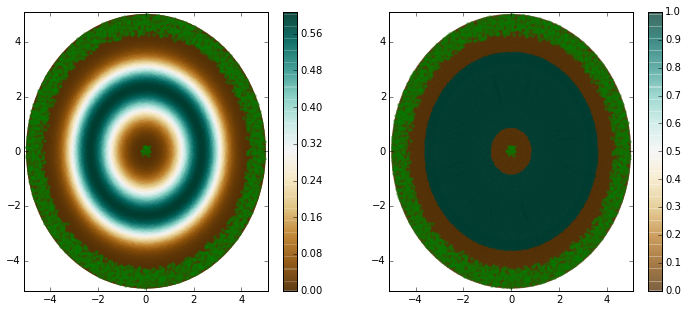

In [10]:
## Find regions where the gradient is low - these are places the low point fixer can't work and where a different transport model
## for sediment could be helpful.


fig, (plot1, plot2) = plt.subplots(1,2)
fig.set_size_inches(12,5)

plot1.set_xlim(-5.1, 5.1)
plot1.set_ylim(-5.1, 5.1)
plot2.set_xlim(-5.1, 5.1)
plot2.set_ylim(-5.1, 5.1)

smooth_grad1 = mesh5.local_area_smoothing(mesh5.slope, its=0, centre_weight=0.5)
flat_spot_field = np.where(smooth_grad1 < smooth_grad1.max() / 10, 0.0, 1.0)
flat_spots = np.where(smooth_grad1 < smooth_grad1.max() / 10, True, False)

sm1 = mesh5.add_node_data_to_plot(plot1, mesh5.slope, cmap=cm.BrBG,  shading="gouraud", alpha=0.75)
fig.colorbar(sm1, ax=plot1)
plot1.scatter(mesh5.x[mesh5.low_points], mesh5.y[mesh5.low_points],12, marker="o", color="g", alpha=0.5, linewidth=0.0)
#plot1.scatter(mesh5.x[not_so_low_points], mesh5.y[not_so_low_points],10, marker="s", alpha=0.75, linewidth=0.0, color="r")


sm2 = mesh5.add_node_data_to_plot(plot2, erosion_deposition_rate, vmin=-maxED, vmax=maxED, cmap=cm.RdBu_r,  shading="gouraud", alpha=1.0) #, vmax=maxDR)
sm2 = mesh5.add_node_data_to_plot(plot2, flat_spot_field, cmap=cm.BrBG,  shading="gouraud", alpha=0.5)
plot2.scatter(mesh5.x[mesh5.low_points], mesh5.y[mesh5.low_points],12, marker="o", color="g", alpha=0.5, linewidth=0.0)
#plot2.scatter(mesh5.x[not_so_low_points], mesh5.y[not_so_low_points],10, marker="s", alpha=0.25, linewidth=0.0, color="r")

fig.colorbar(sm2, ax=plot2)

fig.savefig("AAA-gradient.png", dpi=600)



In [11]:
%%sh

open "AAA-gradient.png"

In [ ]:
# %%prun -s cumulative -q -T prunErosionDeposition

# Test the time evolution with a mid-point method

import time as systime

kappa = 1.0e-3
critical_slope = 2.0      # Critical value - assume slides etc take over to limit slope
lowest_slope   = 1.0e-3   # The slope where we cut off the erosion / deposition algorithm
base = 0.0
totalSteps = 0

mesh5.verbose = False

typical_l = np.sqrt(mesh5.area)

# Reset the height (or not)

h5 = mesh5.height
reset = True

if reset:
    totalSteps = 0
    h5 = np.exp(-0.025*(x5**2 + y5**2)**2) + 0.001 * np.random.rand(len(x5))
    mesh5.rainfall_pattern = h5**2  # say !
    mesh5.rainfall_pattern[ mesh5.x > 0] *= ( 1.0 - mesh5.x[ mesh5.x > 0] * 0.2 )**3
    mesh5.update_height(h5)
    mesh5.update_surface_processes()
    


time = 0.0
viz_time= 0.0
vizzes = 0

running_average_uparea = mesh5.cumulative_flow(mesh5.area * mesh5.rainfall_pattern)

for step in range(0,250):
    totalSteps += 1
    walltime = systime.clock()
    
    delta = h5-mesh5.height
    efficiency = 0.01 # + np.where(delta < -0.00, 0.01, 0.0)
  
    # Erosion + deposition
    
    erosion_rate, deposition_rate, stream_power = \
         mesh5.stream_power_erosion_deposition_rate2(efficiency=efficiency, 
                                                    smooth_power=1, 
                                                    smooth_low_points=0, 
                                                    smooth_erosion_rate=0, 
                                                    smooth_deposition_rate=2, 
                                                    smooth_operator=mesh5.downhill_smoothing,
                                                    centre_weight_u=0.666, centre_weight=0.75)

        
    # Smooth deposition in flat areas ... perhaps this could be replaced by multiple pathways in 
    # flat areas.
    
    erosion_deposition_rate = erosion_rate - deposition_rate
    erosion_timestep    = ((mesh5.slope + lowest_slope) * typical_l / (np.abs(erosion_rate)+0.000001)).min()
    deposition_timestep = ((mesh5.slope + lowest_slope) * typical_l / (np.abs(deposition_rate)+0.000001)).min()
         
    # Diffusion
        
    diffDz, diff_timestep =  mesh5.landscape_diffusion_critical_slope(kappa, critical_slope, True)
        
    ## Mid-point method. Update the height and use this to estimate the new rates of 
    ## Change. Note that we have to assume that the flow pattern doesn't change for this 
    ## to work. This means we can't call the methods which do a full update !
    
    timestep = min(erosion_timestep, deposition_timestep, diff_timestep)
    time = time + timestep
    viz_time = viz_time + timestep

    # Height predictor step (at half time)
    
    height0 = mesh5.height.copy()
    mesh5.height -= 0.5 * timestep * (erosion_deposition_rate - diffDz )
    mesh5.height = np.clip(mesh5.height, base, 1.0e9)   
    
    # Deal with internal drainages !
    mesh5.height = mesh5.handle_low_points2(base, 5)  
    gradZx, gradZy = mesh5.delaunay_grad(mesh5.height)
    mesh5.slope = np.sqrt(gradZx**2+gradZy**2)   
    
    # Recalculate based on mid-point values
    
    erosion_rate, deposition_rate, stream_power = \
         mesh5.stream_power_erosion_deposition_rate2(efficiency=efficiency, 
                                                    smooth_power=1, 
                                                    smooth_low_points=0, 
                                                    smooth_erosion_rate=0, 
                                                    smooth_deposition_rate=2, 
                                                    smooth_operator=mesh5.downhill_smoothing,
                                                    centre_weight_u=0.666, centre_weight=0.75)
        
        
    # Smooth deposition in flat areas ...
             
    erosion_deposition_rate = erosion_rate - deposition_rate
    erosion_timestep    = ((mesh5.slope + lowest_slope) * typical_l / (np.abs(erosion_rate)+0.000001)).min()
    deposition_timestep = ((mesh5.slope + lowest_slope) * typical_l / (np.abs(deposition_rate)+0.000001)).min()
   
    diffDz, diff_timestep =  mesh5.landscape_diffusion_critical_slope(kappa, critical_slope, True)
 
    timestep = min(erosion_timestep, deposition_timestep, diff_timestep)
    
    # Now take the full timestep

    height0 -= timestep * (erosion_deposition_rate - diffDz )
    mesh5.height = np.clip(height0, base, 1.0e9)  
    mesh5.height = mesh5.handle_low_points2(base, 5)

    mesh5.update_height(mesh5.height)
    mesh5.update_surface_processes()
    
    running_average_uparea = 0.5 * running_average_uparea + 0.5 * mesh5.cumulative_flow(mesh5.area * mesh5.rainfall_pattern)


    
    if step%10 == 0:
        print "{:04d} - ".format(step), \
          " dt - {:.5f} ({:.5f}, {:.5f}, {:.5f})".format(timestep, diff_timestep, erosion_timestep, deposition_timestep), \
          " time - {:.4f}".format(time), \
          " Max slope - {:.3f}".format(mesh5.slope.max()), \
          " Step walltime - {:.3f}".format(systime.clock()-walltime)
            
        # print low_point_report
              
    # Store data
    
    if( viz_time > 0.025 or step==0):

        viz_time = 0.0
        vizzes = vizzes + 1

        delta = h5-mesh5.height
        smoothHeight = mesh5.local_area_smoothing(mesh5.height, its=2, centre_weight=0.75)
         
        mesh5.dump_to_file("Sombrero1.{:04d}".format(vizzes), delta=delta, 
                            uparea=running_average_uparea, erosion=erosion_deposition_rate)

